In [1]:
from PIL import Image, ImageOps
import numpy as np
import scipy as sc
from scipy import signal

from SSIM_PIL import compare_ssim

import matplotlib.pyplot as PLT
%matplotlib inline 
#%matplotlib notebook



# Opciones FFTW

In [2]:
import multiprocessing
import pyfftw

pyfftw.config.NUM_THREADS = multiprocessing.cpu_count()
pyfftw.config.PLANNER_EFFORT = 'FFTW_MEASURE'

pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(10)

# Funciones genericas

In [3]:
def plotNImgs(U, N, txtN=[], shwFlag=True):
    
    if shwFlag is False:
       return
    
    figure, f = PLT.subplots(ncols=N, figsize=(16*N, 16))

    for k in np.arange(N):
        vMin = U[k].min()
        vMax = U[k].max()
        f[k].imshow(Image.fromarray( np.uint8( np.floor( 255*(U[k]-vMin)/(vMax-vMin) ) ) ), cmap='gray')
        if(len(txtN)>0):
            f[k].set_title(txtN[k],fontsize='24')
            f[k].set_axis_off()
    
    return          

def SnPnoise(U,p):
    
    uMax = U.max()
    uMin = U.min()
    
    V = np.zeros(U.shape,dtype=float)
    mask = np.random.binomial(1,1-p,U.shape)
    noise = np.random.binomial(1,0.5,U.shape)
    
    V = U*mask + (1-mask)*noise*uMax +  (1-mask)*(1-noise)*uMin
    
    return V

def gaussNoise(U,sigma):
    
    return (U + np.random.normal(0, sigma, U.shape) )


def saveImg(U,fName):
    vMin = U.min()
    vMax = U.max()
    z = Image.fromarray( np.uint8( np.floor( 255*(U-vMin)/(vMax-vMin) ) ) )
    
    z.save(fName)
    
    return

def snr(Ref, U):
    
    num = np.var( Ref.flatten() )
    den = np.mean( np.abs( Ref.flatten() - U.flatten() )**2 )
    
    return( 10*np.log10(num/den))

def psnr(Ref, U):
    
    num = ( Ref.max() - Ref.min() )**2
    den = np.mean( np.abs( Ref.flatten() - U.flatten() )**2 )
    
    return( 10*np.log10(num/den))

def mse(Ref, U):
    
    return( np.mean( np.abs( Ref.flatten() - U.flatten() )**2 ) )

def ssim(Ref, U):

    vMin = Ref.min()
    vMax = Ref.max()
    charRef = Image.fromarray( np.uint8( np.floor( 255*(Ref-vMin)/(vMax-vMin) ) ) )
    
    vMin = U.min()
    vMax = U.max()
    charU = Image.fromarray( np.uint8( np.floor( 255*(U-vMin)/(vMax-vMin) ) ) )
    
    return( compare_ssim(charRef, charU) )
    
    
def gauss2D(shape=(3,3),sigma=0.5):
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h


def colorConv2d(U, H, boundary='symm', mode='same'):
    nDims = U.shape
    
    V = 0*U
    for k in range( nDims[2] ):
        V[:,:,k] = signal.convolve2d(U[:,:,k], H, boundary=boundary, mode=mode)
    
    return(V)


def conv2D(U, H,  boundary='symm', mode='same'):

    if H.size == 1:  # caso identidad
       return U*H 

    if len(U.shape)==3:
        z = colorConv2d(U, H, boundary=boundary, mode=mode)
    else:
        z = signal.convolve2d(U, H, boundary=boundary, mode=mode)

    return(z)
        
    
def fwOp_Conv(h, Img, vecFlag=False, dims=[]):
        
    if vecFlag:
        Img.shape = dims
        
    if len(Img.shape)==3:
        z = colorConv2d(Img, h, boundary='symm', mode='same').ravel()
    else:
        z = signal.convolve2d(Img, h, boundary='symm', mode='same').ravel()
    
    return z

# Imagenes / Operador lineal

In [4]:
# imgs = [ ImageOps.grayscale( Image.open('./testImgs/lena_gray.png') ) ]
# imgs.append( Image.open('./testImgs/barbara.png')  )
# imgs.append( ImageOps.grayscale(Image.open('./testImgs/mandrillgr.png')  ))
# imgs.append( ImageOps.grayscale(Image.open('./testImgs/peppersgray.png'))  )
imgs = [ Image.open('./testImgs/lena_rgb.png') ]
imgs.append( Image.open('./testImgs/barbara_rgb.jpg')  )
imgs.append( Image.open('./testImgs/mandrill.png')  )
imgs.append( Image.open('./testImgs/Peppers512rgb.png')  )
u = []

for k in range(len(imgs)):
    u.append(np.asarray(imgs[k]).astype(float)/255.)

H = []

H.append( np.ones((1,1)) )             # identidad
H.append( gauss2D((9,9),10.0) )        # Gaussian
H.append( (1./25.)*np.ones((5,5)) )    # Average



# Selecciona nivel de ruido

In [5]:
sigma = 0.5# Noise level


imgBlur = []

mPsnr = []
mSnr  = []
mMse  = []
mSsim = []


l = 0
for k in range(len(u)):
    for n in range(len(H)):
        
        imgBlur.append( gaussNoise( conv2D(u[k], H[n] ), sigma ) )
        
        # Metricas
        mPsnr.append( psnr(u[k], imgBlur[l]) )
        mSnr.append(  snr(u[k],  imgBlur[l]) )
        mMse.append(  mse(u[k],  imgBlur[l]) )
        mSsim.append( ssim(u[k], imgBlur[l]) )
        
        # Plot 
        txtN = []
        txtN.append('Original')

        txtN.append('Observada \n PSNR: {:01.2f} \n SNR: {:01.2f} \n MSE: {:01.2g} \n SSIM: {:01.2f}'.format(mPsnr[l],mSnr[l],mMse[l],mSsim[l]))

        imgShow = []
        imgShow.append(u[k])
        imgShow.append(imgBlur[l])

        plotNImgs(imgShow, 2, txtN, shwFlag=False)        
        
        l += 1

# Funciones operador en frecuencia

In [9]:
def getImg_Fsym(U, nPad):
    
    nU = U.shape

    L = np.floor( (np.asarray(nPad)+0.5)/2 )
    L = L.astype(int)

    if len(nU) == 2:
        uSymm = np.pad(U, ((L[0],L[0]), (L[1],L[1]) ), mode='symmetric') 
        
    if len(nU) == 3:
        uSymm = np.pad(U, ((L[0],L[0]), (L[1],L[1]), (0,0) ), mode='symmetric')
        
    if len(nU) == 4:
        uSymm = np.pad(U, ((L[0],L[0]), (L[1],L[1]), (0,0), (0,0) ), mode='symmetric')
        
    nUsymm = uSymm.shape

    UF = pyfftw.interfaces.numpy_fft.rfft2(uSymm, s=(nUsymm[0]+nPad[0]-1, nUsymm[1]+nPad[1]-1), axes=(0,1))
    
    return UF, nUsymm


def getKernel_Fsym(H, nUsym, shpFlag=True):

    if H.size == 1:
       return H.ravel()
    
    if shpFlag:
       nH = H.shape
       HF = pyfftw.interfaces.numpy_fft.rfft2(H, s=(nUsym[0]+nH[0]-1,nUsym[1]+nH[1]-1), axes=(0,1))
    else:
       HF = pyfftw.interfaces.numpy_fft.rfft2(H, s=(nUsym[0],nUsym[1]), axes=(0,1))
    
    if len(nUsym) == 3: 
        
        HF = np.repeat(HF[..., np.newaxis], 3, axis=-1)
        if len(HF.shape) == 4:
            HF = np.swapaxes(HF,2,3)
        
    return HF

def getROI(Usym, nU, L=np.array([0,0]) ):
           
    if (len(nU))==2:
        z =Usym[ 0+L[0]:nU[0]+L[0], 0+L[1]:nU[1]+L[1] ]
    else:
        z =Usym[ 0+L[0]:nU[0]+L[0], 0+L[1]:nU[1]+L[1], : ]
        
        
        
    return z


def genDxDy_F(nDims, shpFlag=True):
    
    dx = np.zeros((2,2))
    dx[0,0] =  1.
    dx[0,1] = -1.

    dy = np.zeros((2,2))
    dy[0,0] =  1.
    dy[1,0] = -1.
    
    dx = dx[...,np.newaxis]
    dy = dy[...,np.newaxis]
        
    return( getKernel_Fsym(np.concatenate( (dx,dy), axis=-1), nDims, shpFlag) )




# Operador proximal

In [10]:
def shrinkl1TV(v,lmb):

    sq = np.sum(v**2.0, axis=-1, keepdims=True) 
    if len(sq.shape) <= 3:
        sq = np.sqrt(sq)
    else:
        sq = np.sqrt( np.sum(sq,axis=-2, keepdims=True) )
        
    th = np.clip(sq - lmb, 0, float('Inf'))
    
    w =  np.where(sq==0, 0, th)/np.where(sq==0, 1, sq)
    

    return(w*v)

def shrinkl0TV(v,lmb):

    sq = np.sum(np.abs(v), axis=-1, keepdims=True)  
    if len(sq.shape) <=3:
        th = sq < np.sqrt(2.*lmb)
    else:
        sq=np.sum(sq,axis=-2, keepdims=True)
        th = sq < np.sqrt(2.*lmb)
    w =  np.where(th, 0., 1.)
        
    return(w*v)



# TV

In [14]:
from timeit import default_timer as timer


def admm_l0tv(b, H, lmb, nIter, rhoFactor=10, relax=1.0, flagPCost=True, flagSymm=True):

    
    Tstart = timer()
    
    tvStats = np.zeros((nIter,5), dtype=float)  #  k, cost, L2, TV, timer
    
    bShape = b.shape
    
    if flagSymm:
       bF, symDims = getImg_Fsym(b, (1,1))
       HF = getKernel_Fsym(H, symDims, shpFlag=False)
        
       DF = genDxDy_F(symDims, shpFlag=False)
    
       L = np.array([0,0],dtype=int)
    
    else:
       bF, symDims = getImg_Fsym(b, H.shape)
       HF = getKernel_Fsym(H, symDims)

       L = np.floor( (np.asarray(H.shape)+0.5)/2 )
       L = L.astype(int)    
    
       DF = genDxDy_F(symDims)
        
    
    
    # Init Z
    z = np.zeros( (*bShape,2), dtype=float)
    
    # Init C
    c = np.zeros( (*bShape, 2), dtype=float)
    
    #rho = rhoFactor*lmb + 0.1
    rho = rhoFactor
       
    HTH_F = np.conj(HF)*HF 
    DTD_F = np.sum(np.conj(DF)*DF,axis=-1).real
    HTb_F = np.conj(HF)*bF
    
    
    cost = []
    
    for it in range(nIter):
        
        
        # Tikhonov sub-problem
        if flagSymm:
           zcSubs,dummy = getImg_Fsym(z-c, (1,1))
        else:
           zcSubs,dummy = getImg_Fsym(z-c, H.shape)
        
        
        DTzc_F = np.sum(np.conj(DF)*zcSubs, axis=-1)
        
        uF = ( HTb_F + rho*DTzc_F )/( HTH_F + rho*DTD_F)
            
        du  =  getROI( pyfftw.interfaces.numpy_fft.irfft2( np.repeat(uF[...,np.newaxis],2,-1)*DF, axes=(0,1)),  bShape, L )
        
        
        # Prox op (NOTA: pasar como ptr --> ADMM generico )
        if np.abs(relax-1.0) > 0.01:
           z = shrinkl0TV( relax*du + (1-relax)*z + c, lmb/rho)
        else:
           z = shrinkl0TV( du + c, lmb/rho)
        
        # actualiza c
        c += du - z

        # -----------------
        # Statistics
        tvStats[it,0] = it
                        
        tvStats[it,2] = 1.5*np.sum( np.abs(HF*uF - bF)**2.0 )/np.float(b.size)     # NOTA: esto es aproximado
        
        tvStats[it,3] = np.sum( np.sum(np.abs(du),axis=2) > 0.01 )
        
        tvStats[it,1] = tvStats[it,2] + lmb*tvStats[it,3]
                        
        tvStats[it,4] = timer()-Tstart
                        
        if flagPCost:
            print('l0tv', it, tvStats[it,1], tvStats[it,4])
    
        # -----------------    
    
    u =   getROI( pyfftw.interfaces.numpy_fft.irfft2( uF, axes=(0,1) ), bShape, 0*L )
    
    return(u, tvStats)


In [70]:

def fista_l0tv(b, H, lmb, ePar, nIter=np.array([10,5],dtype=int), beta=1./8., flagSymm=True, flagPCost=True):

    
    Tstart = timer()
    
    tvStats = np.zeros((nIter[0],5), dtype=float)  #  k, cost, L2, TV, timer
    
    bShp = b.shape
    
    if flagSymm:
       bF, symDims = getImg_Fsym(b, (1,1))
       HF = getKernel_Fsym(H, symDims, shpFlag=False)
        
       DF = genDxDy_F(symDims, shpFlag=False)
    
       L = np.array([0,0],dtype=int)
    
    else:
       bF, symDims = getImg_Fsym(b, H.shape)      # Dx / Dy <--> 2x1 filter (2,2)
       HF = getKernel_Fsym(H, symDims)

       L = np.floor( (np.asarray(H.shape)+0.5)/2 )
       L = L.astype(int)    
    
       DF = genDxDy_F((symDims[0]+H.shape[0]-1,symDims[1]+H.shape[1]-1,symDims[2]),shpFlag=False)
       print (symDims) 
    
    bF_norm = 1.5*np.sum( np.abs( bF )**2.0 )/np.float(b.size) 
    # Dx*b, Dy*b

    
    HTH_F = np.conj(HF)*HF 
    DTD_F = np.sum(np.conj(DF)*DF,axis=-1).real
    HTb_F = np.conj(HF)*bF
#     print (HTH_F.shape)
#     print (DTD_F.shape)
#     print (HTb_F.shape)
    
    lmb1 = np.sqrt(2.*ePar*lmb)
    lmb2 = ePar
    
    
    x1_uF = np.zeros( bF.shape, dtype=float)
    y_uF  = x1_uF.copy()
    
    # Outer-loop
    for it in range(nIter[0]):
#         print ("a")
        if it > 0:
            
            # gradient
            nabla0 = HTH_F*y_uF - HTb_F
            nabla = nabla0 - lmb2*DTD_F*y_uF
            
            # FIXME: Cauchy lagged (flag for others)
            if it%2 == 0:
                den0 = HF*nabla
                den1 = np.einsum('ij...k,ij...->ij...k', DF, nabla )
                alpha = np.sum( np.real( np.conj(nabla) * nabla ) ) / (np.sum( np.real( np.conj(den0) * den0 ) ) + np.sum( np.real( np.conj(den1) * den1 ) ))
                        
            #DxDy_BF = np.einsum('ijk,ij->ijk', DF, x1_uF - alpha*nabla )
            DxDy_BF = np.einsum('ij...k,ij...->ij...k', DF, y_uF - alpha*nabla )
            
            x1_PF *= 0.
            y_PF  *= 0.
            
        else:
            
            
            # gradient
            nabla = -HTb_F

            # FIXME: Cauchy (1st step)
            den   = HF*nabla
            alpha = np.sum( np.real( np.conj(nabla) * nabla ) ) / np.sum( np.real( np.conj(den) * den ) )
            
            DxDy_BF = np.einsum('ij...k,ij...->ij...k', DF, -alpha*nabla)
            
            x1_PF = np.zeros( (*bF.shape,2), dtype=float)
            y_PF  = x1_PF.copy()
            
    
        # inner-loop
        for itTV in range(nIter[1]):

            # \nabla 0.5|| hx*p + hy*q - b_k ||_2^2  (in freq)
            DFT_PF = np.einsum('ij...k,ij...k->ij...', np.conj(DF), y_PF)
        
            gF = alpha*lmb1*np.einsum('ij...k,ij...->ij...k', DF, DFT_PF) - DxDy_BF
    
    
            # FISTA step
    
            x0_PF = x1_PF.copy()
    
            x1_PF = y_PF - (beta/(alpha*lmb1))*gF
        
            # normalization step
            x1 = pyfftw.interfaces.numpy_fft.irfft2( x1_PF, axes=(0,1))
        
            mask = np.sqrt(x1[...,0]*x1[...,0] + x1[...,1]*x1[...,1])
    
            x1 = np.einsum('ij...k,ij...->ij...k', x1, 1./np.where(mask>1,mask,1.0))
        
            # back to freq
            if flagSymm:
               x1_PF,dummy = getImg_Fsym(x1, (1,1))
            else:
               x1_PF,dummy = getImg_Fsym(x1, (1,1)) #(2,2)

        
            gammaTV = float(itTV-1)/float(itTV+2)
            
            y_PF = x1_PF + gammaTV*(x1_PF - x0_PF)
        
        
    
#             # normalization step
#             y = pyfftw.interfaces.numpy_fft.irfft2( y_PF, axes=(0,1))
            
#             mask = np.sqrt(y[...,0]*y[...,0] + y[...,1]*y[...,1])
    
#             y = np.einsum('ij...k,ij...->ij...k', y, 1./np.where(mask>1,mask,1.0))
        
#             # back to freq
#             if flagSymm:
#                y_PF,dummy = getImg_Fsym(y, (1,1))
#             else:
#                y_PF,dummy = getImg_Fsym(y, (2,2))

            
        # (outer) FISTA step
            
        x0_uF = x1_uF.copy()

        x1_uF = y_uF - alpha*nabla - alpha*lmb1*np.einsum('ij...k,ij...k->ij...', np.conj(DF), y_PF)
            
        gamma = float(it-1)/float(it+2)
        
        y_uF = x1_uF + gamma*(x1_uF - x0_uF)
    
        # -----------------
        # Statistics
        tvStats[it,0] = it
        
        #bF_lHF = np.einsum('ijk,ijk->ij', np.conj(DF), y_PF)  # conj(Hx)*pF +conj(Hy)*qF 
        tvStats[it,2] = 1.5*np.sum( np.abs( HF*x1_uF - bF  )**2.0 )/np.float(b.size)     # NOTA: esto es aproximado
        
        tvStats[it,3] = np.sum( np.sqrt(np.sum( np.abs( pyfftw.interfaces.numpy_fft.irfft2( np.einsum('ij...k,ij...->ij...k', DF,  x1_uF), axes=(0,1)) ), axis=2 )) > 0.1)
        
        tvStats[it,1] = tvStats[it,2] + tvStats[it,3]
        #tvStats[it,1] = tvStats[it,3]
                        
        tvStats[it,4] = timer()-Tstart
                        
        if flagPCost:
            print('QE-l0tv', it, tvStats[it,1], tvStats[it,4])
    
        # -----------------    
    
    
    u = pyfftw.interfaces.numpy_fft.irfft2( x1_uF, axes=(0,1))
    
    
    return (u, tvStats)

In [79]:
def fista_l1tv(b, H, lmb, nIter=np.array([10,5],dtype=int), beta=1./8., flagSymm=True, flagPCost=True):

    
    Tstart = timer()
    
    tvStats = np.zeros((nIter[0],5), dtype=float)  #  k, cost, L2, TV, timer
    
    bShp = b.shape
    
    if flagSymm:
       bF, symDims = getImg_Fsym(b, (1,1))
       HF = getKernel_Fsym(H, symDims, shpFlag=False)
        
       DF = genDxDy_F(symDims, shpFlag=False)
    
       L = np.array([0,0],dtype=int)
    
    else:
       bF, symDims = getImg_Fsym(b, (2,2))      # Dx / Dy <--> 2x1 filter
       HF = getKernel_Fsym(H, symDims)

       L = np.floor( (np.asarray((2,2))+0.5)/2 )
       L = L.astype(int)    
    
       DF = genDxDy_F(symDims)
        
    
    bF_norm = 1.5*np.sum( np.abs( bF )**2.0 )/np.float(b.size) 
    # Dx*b, Dy*b

    
    
    
    x1_uF = np.zeros( bF.shape, dtype=float)
    y_uF  = x1_uF.copy()
    
    # Outer-loop
    for it in range(nIter[0]):
    
        if it > 0:

            # gradient
            nabla = np.conj(HF)*(HF*y_uF-bF)
            
            # FIXME: Cauchy lagged (flag for others)
            if it%2 == 0:
                den = HF*nabla
                alpha = np.sum( np.real( np.conj(nabla) * nabla ) ) / np.sum( np.real( np.conj(den) * den ) )            
            
            DxDy_BF = np.einsum('ij...k,ij...->ij...k', DF, y_uF - alpha*nabla )
            
            x1_PF *= 0.
            y_PF  *= 0.
            
        else:
            
            # gradient
            nabla = -np.conj(HF)*bF

            # FIXME: Cauchy (1st step)
            den   = HF*nabla
            alpha = np.sum( np.real( np.conj(nabla) * nabla ) ) / np.sum( np.real( np.conj(den) * den ) )
            
            DxDy_BF = np.einsum('ij...k,ij...->ij...k', DF, -alpha*nabla)
            
            x1_PF = np.zeros( (*bF.shape,2), dtype=float)
            y_PF  = x1_PF.copy()
            
    
        # inner-loop
        for itTV in range(nIter[1]):

            # \nabla 0.5|| hx*p + hy*q - b_k ||_2^2  (in freq)
            DFT_PF = np.einsum('ij...k,ij...k->ij...', np.conj(DF), y_PF)
        
            gF = alpha*lmb*np.einsum('ij...k,ij...->ij...k', DF, DFT_PF) - DxDy_BF
    
    
            # FISTA step
    
            x0_PF = x1_PF.copy()
        
    
            x1_PF = y_PF - (beta/(alpha*lmb))*gF
#             # normalization step
#             x1 = pyfftw.interfaces.numpy_fft.irfft2( x1_PF, axes=(0,1))
        
#             mask = np.sqrt(x1[...,0]*x1[...,0] + x1[...,1]*x1[...,1])
    
#             x1 = np.einsum('ij...k,ij...->ij...k', x1, 1./np.where(mask>1,mask,1.0))
        
#             # back to freq
#             if flagSymm:
#                x1_PF,dummy = getImg_Fsym(x1, (1,1))
#             else:
#                x1_PF,dummy = getImg_Fsym(x1, (2,2))

        
            gammaTV = float(itTV-1)/float(itTV+2)
            y_PF = x1_PF + gammaTV*(x1_PF - x0_PF)
        
                 # normalization step
            y = pyfftw.interfaces.numpy_fft.irfft2( y_PF, axes=(0,1))
            
            mask = np.sqrt(y[...,0]*y[...,0] + y[...,1]*y[...,1])
    
            y = np.einsum('ij...k,ij...->ij...k', y, 1./np.where(mask>1,mask,1.0))
        
            # back to freq
            if flagSymm:
               y_PF,dummy = getImg_Fsym(y, (1,1))
            else:
               y_PF,dummy = getImg_Fsym(y, (2,2))
    
            
            
        # (outer) FISTA step
            
        x0_uF = x1_uF.copy()
        x1_uF = y_uF - alpha*nabla - alpha*lmb*np.einsum('ij...k,ij...k->ij...', np.conj(DF), x1_PF)
    
        gamma = float(it-1)/float(it+2)
        y_uF = x1_uF + gamma*(x1_uF - x0_uF)
    
    
        # -----------------
        # Statistics
        tvStats[it,0] = it
        
        #bF_lHF = np.einsum('ijk,ijk->ij', np.conj(DF), y_PF)  # conj(Hx)*pF +conj(Hy)*qF 
        tvStats[it,2] = 1.5*np.sum( np.abs( HF*x1_uF - bF  )**2.0 )/np.float(b.size)     # NOTA: esto es aproximado
        
        #tvStats[it,3] = lmb*np.sum( np.abs( np.einsum('ijk,ijk->ij', np.conj(x1_PF), np.einsum('ijk,ij->ijk', DF, x1_uF)) ) )
        #tvStats[it,3] = lmb*np.sum( pyfftw.interfaces.numpy_fft.irfft2( np.einsum('ijk,ij->ijk', DF, x1_uF), axes=(0,1))**2. )
        tvStats[it,3] = lmb*np.sum( np.sqrt(np.sum( pyfftw.interfaces.numpy_fft.irfft2( np.einsum('ij...k,ij...->ij...k', DF,  x1_uF), axes=(0,1))**2., axis=2 )))
        
        tvStats[it,1] = tvStats[it,2] + tvStats[it,3]
        #tvStats[it,1] = tvStats[it,3]
                        
        tvStats[it,4] = timer()-Tstart
                        
        if flagPCost:
            print('l1tv', it, tvStats[it,1], tvStats[it,4])
    
        # -----------------    
    
    
    u = pyfftw.interfaces.numpy_fft.irfft2( x1_uF, axes=(0,1))
    
    
    return (u, tvStats)

27.761567441993975
6.30274065300182
41.78964926300978


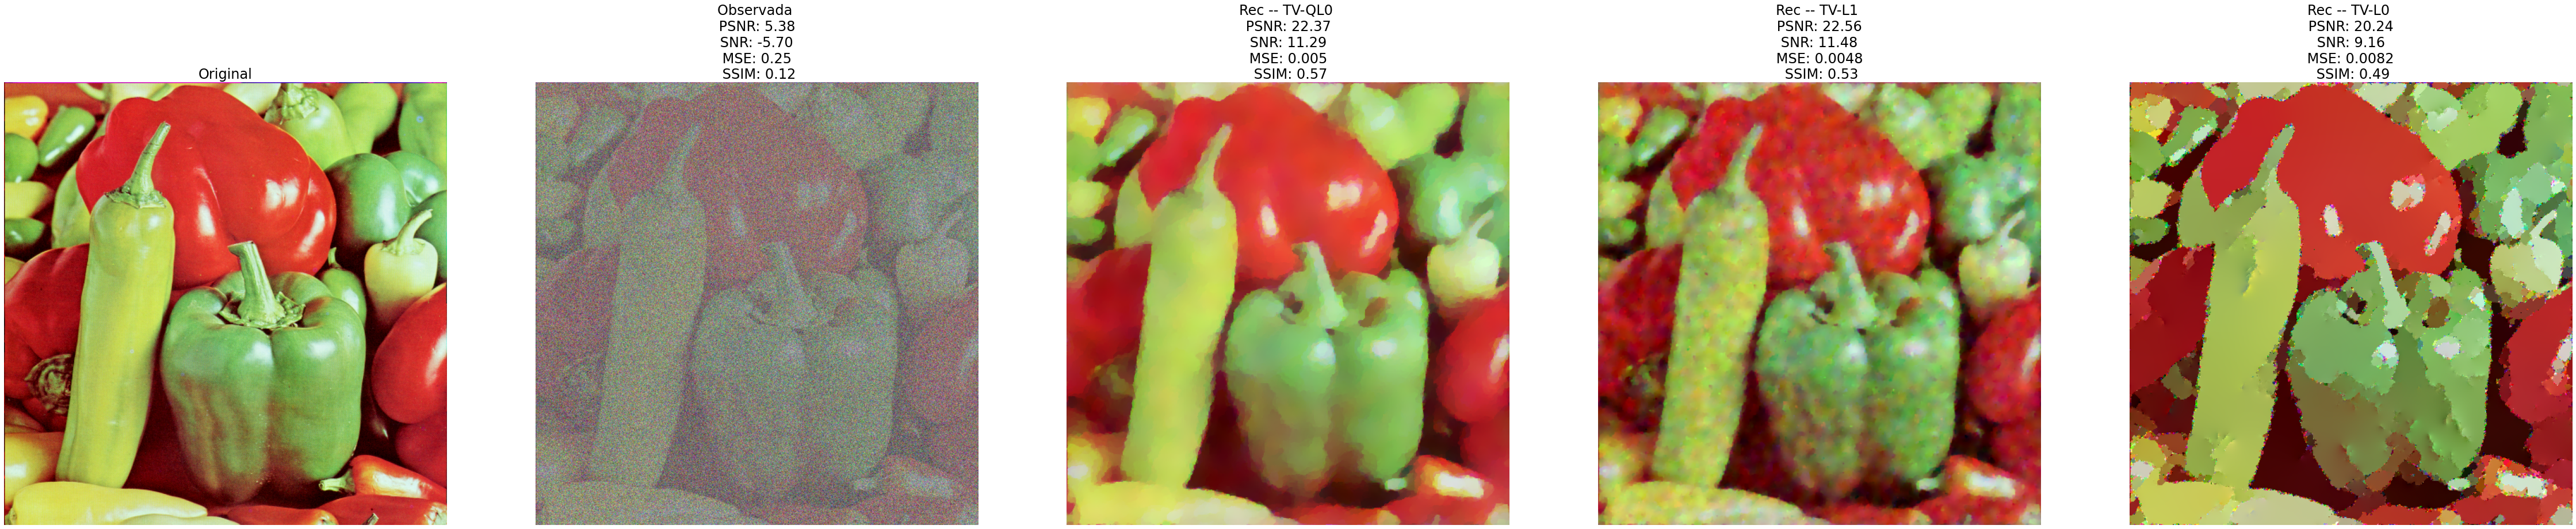

In [149]:
k = 3 # img
n = 0  # filtro  -- 0:Identidad, 1:Gaussian, 2:average

l = k*len(H) + n

switcher = { 0:0.0005, 0.05:0.0225, 0.1:0.15, 0.25:0.3, 0.5:0.5 }
lmb_l1 = switcher.get(sigma, 0.1)

switcher = { 0:0.01, 0.05:0.075, 0.1:1.5, 0.25:6.5, 0.5:25.0 }
lmb_Ql0 = switcher.get(sigma, 0.1)

switcher = { 0:0.0005, 0.05:0.005, 0.1:0.01, 0.25:0.06, 0.5:0.15 }
lmb_l0 = switcher.get(sigma, 0.1)

# l1tv call
#imgRec0, Stats0 = fista_l0tv(imgBlur[l], H[n], 0.075, 0.01, nIter=np.array([20,20],dtype=int), beta=1./8., flagSymm=True, flagPCost=True) 
imgRec0, Stats0 = fista_l0tv(imgBlur[l], H[n], lmb_Ql0, 0.01, nIter=np.array([20,30],dtype=int), beta=1./8., flagSymm=True, flagPCost=False) 
imgRec1, Stats1 = fista_l1tv(imgBlur[l], H[n], lmb_l1 , nIter=np.array([20,20],dtype=int), beta=1./8., flagSymm=True, flagPCost=False) 
imgRec2, Stats2 = admm_l0tv(imgBlur[l], H[n], 0.95, 40, rhoFactor=20, relax=1.5, flagPCost=False, flagSymm=True) 

print(Stats1[19,4])
print(Stats2[39,4])
print(Stats0[19,4])

imgRec0 = np.clip(imgRec0, 0, 1)
imgRec1 = np.clip(imgRec1, 0, 1)
imgRec2 = np.clip(imgRec2, 0, 1)

# # 
metrics_TV = []

metrics_TV.append( psnr(u[k], imgRec0) )
metrics_TV.append(  snr(u[k], imgRec0) )
metrics_TV.append(  mse(u[k], imgRec0) )
metrics_TV.append( ssim(u[k], imgRec0) )

metrics_TV.append( psnr(u[k], imgRec1) )
metrics_TV.append(  snr(u[k], imgRec1) )
metrics_TV.append(  mse(u[k], imgRec1) )
metrics_TV.append( ssim(u[k], imgRec1) )

metrics_TV.append( psnr(u[k], imgRec2) )
metrics_TV.append(  snr(u[k], imgRec2) )
metrics_TV.append(  mse(u[k], imgRec2) )
metrics_TV.append( ssim(u[k], imgRec2) )


# # Plot 
txtN = []
txtN.append('Original')
txtN.append('Observada \n PSNR: {:01.2f} \n SNR: {:01.2f} \n MSE: {:01.2g} \n SSIM: {:01.2f}'.format(mPsnr[l],mSnr[l],mMse[l],mSsim[l]))
txtN.append('Rec -- TV-QL0 \n PSNR: {:01.2f} \n SNR: {:01.2f} \n MSE: {:01.2g} \n SSIM: {:01.2f}'.format(metrics_TV[0],metrics_TV[1],metrics_TV[2],metrics_TV[3]))
txtN.append('Rec -- TV-L1 \n PSNR: {:01.2f} \n SNR: {:01.2f} \n MSE: {:01.2g} \n SSIM: {:01.2f}'.format(metrics_TV[4],metrics_TV[5],metrics_TV[6],metrics_TV[7]))
txtN.append('Rec -- TV-L0 \n PSNR: {:01.2f} \n SNR: {:01.2f} \n MSE: {:01.2g} \n SSIM: {:01.2f}'.format(metrics_TV[8],metrics_TV[9],metrics_TV[10],metrics_TV[11]))

imgShow = []
imgShow.append(u[k])
imgShow.append(imgBlur[l])
imgShow.append(imgRec0)
imgShow.append(imgRec1)
imgShow.append(imgRec2)


plotNImgs(imgShow, 5, txtN)        

